In [1]:
from __future__ import division, print_function, absolute_import
import tensorflow as tf
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d, avg_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression
from tflearn.data_utils import shuffle
from six.moves import cPickle as pickle
from tflearn.layers.merge_ops import merge

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
% matplotlib inline

hdf5 not supported (please install/reinstall h5py)


In [2]:
# Data loading and preprocessing
#root='/home/cc/Data/stanford_car/'
pickle_file = 'Test.pickle'
test_dataset = pickle.load( open( pickle_file, "rb" ) )
print(type(test_dataset))

<type 'dict'>


In [4]:
#Data Assigning and Shuffling
data = test_dataset['data']
labels = test_dataset['labels']

X=data
Y=labels

In [5]:
# Load Graph Model
MODEL = None

with tf.Graph().as_default():
    # Building 'Inception Network'
    network = input_data(shape=[None, 227, 227, 3])
    conv1_7_7 = conv_2d(network, 64, 7, strides=2, activation='relu', name = 'conv1_7_7_s2')
    pool1_3_3 = max_pool_2d(conv1_7_7, 3,strides=2)
    pool1_3_3 = local_response_normalization(pool1_3_3)
    conv2_3_3_reduce = conv_2d(pool1_3_3, 64,1, activation='relu',name = 'conv2_3_3_reduce')
    conv2_3_3 = conv_2d(conv2_3_3_reduce, 192,3, activation='relu', name='conv2_3_3')
    conv2_3_3 = local_response_normalization(conv2_3_3)
    pool2_3_3 = max_pool_2d(conv2_3_3, kernel_size=3, strides=2, name='pool2_3_3_s2')
    inception_3a_1_1 = conv_2d(pool2_3_3, 64, 1, activation='relu', name='inception_3a_1_1')
    inception_3a_3_3_reduce = conv_2d(pool2_3_3, 96,1, activation='relu', name='inception_3a_3_3_reduce')
    inception_3a_3_3 = conv_2d(inception_3a_3_3_reduce, 128,filter_size=3,  activation='relu', name = 'inception_3a_3_3')
    inception_3a_5_5_reduce = conv_2d(pool2_3_3,16, filter_size=1,activation='relu', name ='inception_3a_5_5_reduce' )
    inception_3a_5_5 = conv_2d(inception_3a_5_5_reduce, 32, filter_size=5, activation='relu', name= 'inception_3a_5_5')
    inception_3a_pool = max_pool_2d(pool2_3_3, kernel_size=3, strides=1, )
    inception_3a_pool_1_1 = conv_2d(inception_3a_pool, 32, filter_size=1, activation='relu', name='inception_3a_pool_1_1')

    # merge the inception_3a__
    inception_3a_output = merge([inception_3a_1_1, inception_3a_3_3, inception_3a_5_5, inception_3a_pool_1_1], mode='concat', axis=3)

    inception_3b_1_1 = conv_2d(inception_3a_output, 128,filter_size=1,activation='relu', name= 'inception_3b_1_1' )
    inception_3b_3_3_reduce = conv_2d(inception_3a_output, 128, filter_size=1, activation='relu', name='inception_3b_3_3_reduce')
    inception_3b_3_3 = conv_2d(inception_3b_3_3_reduce, 192, filter_size=3,  activation='relu',name='inception_3b_3_3')
    inception_3b_5_5_reduce = conv_2d(inception_3a_output, 32, filter_size=1, activation='relu', name = 'inception_3b_5_5_reduce')
    inception_3b_5_5 = conv_2d(inception_3b_5_5_reduce, 96, filter_size=5,  name = 'inception_3b_5_5')
    inception_3b_pool = max_pool_2d(inception_3a_output, kernel_size=3, strides=1,  name='inception_3b_pool')
    inception_3b_pool_1_1 = conv_2d(inception_3b_pool, 64, filter_size=1,activation='relu', name='inception_3b_pool_1_1')

    #merge the inception_3b_*
    inception_3b_output = merge([inception_3b_1_1, inception_3b_3_3, inception_3b_5_5, inception_3b_pool_1_1], mode='concat',axis=3,name='inception_3b_output')

    pool3_3_3 = max_pool_2d(inception_3b_output, kernel_size=3, strides=2, name='pool3_3_3')
    inception_4a_1_1 = conv_2d(pool3_3_3, 192, filter_size=1, activation='relu', name='inception_4a_1_1')
    inception_4a_3_3_reduce = conv_2d(pool3_3_3, 96, filter_size=1, activation='relu', name='inception_4a_3_3_reduce')
    inception_4a_3_3 = conv_2d(inception_4a_3_3_reduce, 208, filter_size=3,  activation='relu', name='inception_4a_3_3')
    inception_4a_5_5_reduce = conv_2d(pool3_3_3, 16, filter_size=1, activation='relu', name='inception_4a_5_5_reduce')
    inception_4a_5_5 = conv_2d(inception_4a_5_5_reduce, 48, filter_size=5,  activation='relu', name='inception_4a_5_5')
    inception_4a_pool = max_pool_2d(pool3_3_3, kernel_size=3, strides=1,  name='inception_4a_pool')
    inception_4a_pool_1_1 = conv_2d(inception_4a_pool, 64, filter_size=1, activation='relu', name='inception_4a_pool_1_1')

    inception_4a_output = merge([inception_4a_1_1, inception_4a_3_3, inception_4a_5_5, inception_4a_pool_1_1], mode='concat', axis=3, name='inception_4a_output')


    inception_4b_1_1 = conv_2d(inception_4a_output, 160, filter_size=1, activation='relu', name='inception_4a_1_1')
    inception_4b_3_3_reduce = conv_2d(inception_4a_output, 112, filter_size=1, activation='relu', name='inception_4b_3_3_reduce')
    inception_4b_3_3 = conv_2d(inception_4b_3_3_reduce, 224, filter_size=3, activation='relu', name='inception_4b_3_3')
    inception_4b_5_5_reduce = conv_2d(inception_4a_output, 24, filter_size=1, activation='relu', name='inception_4b_5_5_reduce')
    inception_4b_5_5 = conv_2d(inception_4b_5_5_reduce, 64, filter_size=5,  activation='relu', name='inception_4b_5_5')

    inception_4b_pool = max_pool_2d(inception_4a_output, kernel_size=3, strides=1,  name='inception_4b_pool')
    inception_4b_pool_1_1 = conv_2d(inception_4b_pool, 64, filter_size=1, activation='relu', name='inception_4b_pool_1_1')

    inception_4b_output = merge([inception_4b_1_1, inception_4b_3_3, inception_4b_5_5, inception_4b_pool_1_1], mode='concat', axis=3, name='inception_4b_output')


    inception_4c_1_1 = conv_2d(inception_4b_output, 128, filter_size=1, activation='relu',name='inception_4c_1_1')
    inception_4c_3_3_reduce = conv_2d(inception_4b_output, 128, filter_size=1, activation='relu', name='inception_4c_3_3_reduce')
    inception_4c_3_3 = conv_2d(inception_4c_3_3_reduce, 256,  filter_size=3, activation='relu', name='inception_4c_3_3')
    inception_4c_5_5_reduce = conv_2d(inception_4b_output, 24, filter_size=1, activation='relu', name='inception_4c_5_5_reduce')
    inception_4c_5_5 = conv_2d(inception_4c_5_5_reduce, 64,  filter_size=5, activation='relu', name='inception_4c_5_5')

    inception_4c_pool = max_pool_2d(inception_4b_output, kernel_size=3, strides=1)
    inception_4c_pool_1_1 = conv_2d(inception_4c_pool, 64, filter_size=1, activation='relu', name='inception_4c_pool_1_1')

    inception_4c_output = merge([inception_4c_1_1, inception_4c_3_3, inception_4c_5_5, inception_4c_pool_1_1], mode='concat', axis=3,name='inception_4c_output')

    inception_4d_1_1 = conv_2d(inception_4c_output, 112, filter_size=1, activation='relu', name='inception_4d_1_1')
    inception_4d_3_3_reduce = conv_2d(inception_4c_output, 144, filter_size=1, activation='relu', name='inception_4d_3_3_reduce')
    inception_4d_3_3 = conv_2d(inception_4d_3_3_reduce, 288, filter_size=3, activation='relu', name='inception_4d_3_3')
    inception_4d_5_5_reduce = conv_2d(inception_4c_output, 32, filter_size=1, activation='relu', name='inception_4d_5_5_reduce')
    inception_4d_5_5 = conv_2d(inception_4d_5_5_reduce, 64, filter_size=5,  activation='relu', name='inception_4d_5_5')
    inception_4d_pool = max_pool_2d(inception_4c_output, kernel_size=3, strides=1,  name='inception_4d_pool')
    inception_4d_pool_1_1 = conv_2d(inception_4d_pool, 64, filter_size=1, activation='relu', name='inception_4d_pool_1_1')

    inception_4d_output = merge([inception_4d_1_1, inception_4d_3_3, inception_4d_5_5, inception_4d_pool_1_1], mode='concat', axis=3, name='inception_4d_output')

    inception_4e_1_1 = conv_2d(inception_4d_output, 256, filter_size=1, activation='relu', name='inception_4e_1_1')
    inception_4e_3_3_reduce = conv_2d(inception_4d_output, 160, filter_size=1, activation='relu', name='inception_4e_3_3_reduce')
    inception_4e_3_3 = conv_2d(inception_4e_3_3_reduce, 320, filter_size=3, activation='relu', name='inception_4e_3_3')
    inception_4e_5_5_reduce = conv_2d(inception_4d_output, 32, filter_size=1, activation='relu', name='inception_4e_5_5_reduce')
    inception_4e_5_5 = conv_2d(inception_4e_5_5_reduce, 128,  filter_size=5, activation='relu', name='inception_4e_5_5')
    inception_4e_pool = max_pool_2d(inception_4d_output, kernel_size=3, strides=1,  name='inception_4e_pool')
    inception_4e_pool_1_1 = conv_2d(inception_4e_pool, 128, filter_size=1, activation='relu', name='inception_4e_pool_1_1')


    inception_4e_output = merge([inception_4e_1_1, inception_4e_3_3, inception_4e_5_5,inception_4e_pool_1_1],axis=3, mode='concat')

    pool4_3_3 = max_pool_2d(inception_4e_output, kernel_size=3, strides=2, name='pool_3_3')


    inception_5a_1_1 = conv_2d(pool4_3_3, 256, filter_size=1, activation='relu', name='inception_5a_1_1')
    inception_5a_3_3_reduce = conv_2d(pool4_3_3, 160, filter_size=1, activation='relu', name='inception_5a_3_3_reduce')
    inception_5a_3_3 = conv_2d(inception_5a_3_3_reduce, 320, filter_size=3, activation='relu', name='inception_5a_3_3')
    inception_5a_5_5_reduce = conv_2d(pool4_3_3, 32, filter_size=1, activation='relu', name='inception_5a_5_5_reduce')
    inception_5a_5_5 = conv_2d(inception_5a_5_5_reduce, 128, filter_size=5,  activation='relu', name='inception_5a_5_5')
    inception_5a_pool = max_pool_2d(pool4_3_3, kernel_size=3, strides=1,  name='inception_5a_pool')
    inception_5a_pool_1_1 = conv_2d(inception_5a_pool, 128, filter_size=1,activation='relu', name='inception_5a_pool_1_1')

    inception_5a_output = merge([inception_5a_1_1, inception_5a_3_3, inception_5a_5_5, inception_5a_pool_1_1], axis=3,mode='concat')


    inception_5b_1_1 = conv_2d(inception_5a_output, 384, filter_size=1,activation='relu', name='inception_5b_1_1')
    inception_5b_3_3_reduce = conv_2d(inception_5a_output, 192, filter_size=1, activation='relu', name='inception_5b_3_3_reduce')
    inception_5b_3_3 = conv_2d(inception_5b_3_3_reduce, 384,  filter_size=3,activation='relu', name='inception_5b_3_3')
    inception_5b_5_5_reduce = conv_2d(inception_5a_output, 48, filter_size=1, activation='relu', name='inception_5b_5_5_reduce')
    inception_5b_5_5 = conv_2d(inception_5b_5_5_reduce,128, filter_size=5,  activation='relu', name='inception_5b_5_5' )
    inception_5b_pool = max_pool_2d(inception_5a_output, kernel_size=3, strides=1,  name='inception_5b_pool')
    inception_5b_pool_1_1 = conv_2d(inception_5b_pool, 128, filter_size=1, activation='relu', name='inception_5b_pool_1_1')
    inception_5b_output = merge([inception_5b_1_1, inception_5b_3_3, inception_5b_5_5, inception_5b_pool_1_1], axis=3, mode='concat')

    pool5_7_7 = avg_pool_2d(inception_5b_output, kernel_size=7, strides=1)
    pool5_7_7 = dropout(pool5_7_7, 0.4)
    loss = fully_connected(pool5_7_7, 25,activation='softmax')
    
    #top_k = tflearn.metrics.Top_k(5)
    network = regression(loss, optimizer='momentum',loss='categorical_crossentropy',learning_rate=0.001)


    model = tflearn.DNN(network, checkpoint_path='model_googlenet',max_checkpoints=1, tensorboard_verbose=1)
    model.load("NhL.tflearn")
    MODEL=model

In [6]:
# Define Necessary Functions

def predict(x):
    predict_y = MODEL.predict(x)
    new_y = np.argmax(predict_y, axis=1)
    return new_y.astype(np.uint8)

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

In [14]:
# Single Testing
z=233
print('Prediction:',predict([X[z,]]))
print('Actual:',np.argmax(Y[z]))
#print('position:',Y[z])

Prediction: [9]
Actual: 9


In [15]:
# Group Testing
NoTestingImage=labels.shape[0]
predicted=np.zeros(NoTestingImage)
actual=np.zeros(NoTestingImage)

for i in range (NoTestingImage):
    predicted[i]=predict([X[i,]])
    actual[i]=np.argmax(Y[i])

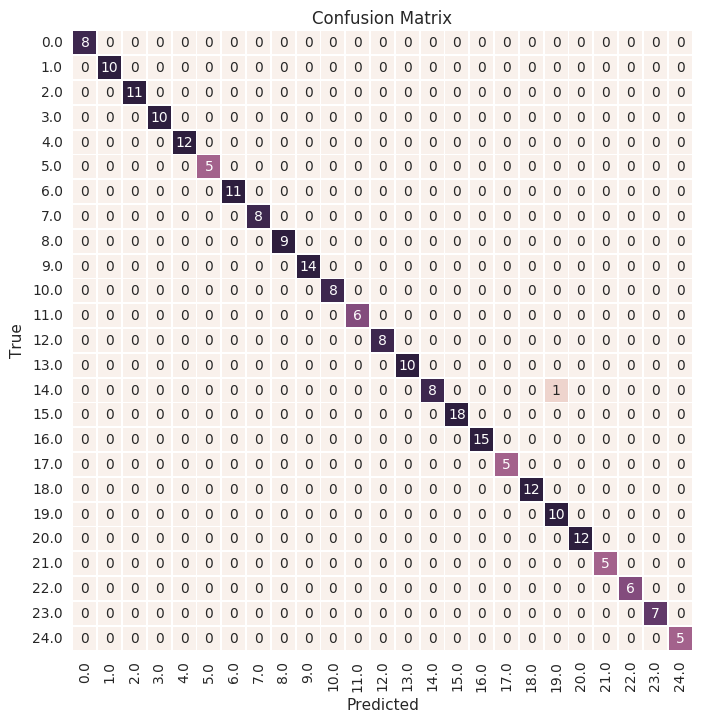

In [18]:
df_confusion = pd.crosstab(actual, predicted)
plt.figure(figsize = (12,8))
sn.heatmap(df_confusion, annot=True,linewidths=.5,cbar=False,square=True, robust=True)
sn.plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()